In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mercedes-benz-greener-manufacturing/train.csv.zip
/kaggle/input/mercedes-benz-greener-manufacturing/sample_submission.csv.zip
/kaggle/input/mercedes-benz-greener-manufacturing/test.csv.zip


In [5]:
# load training data
df_train = pd.read_csv('/kaggle/input/mercedes-benz-greener-manufacturing/train.csv.zip')

# load testing data
df_test = pd.read_csv('/kaggle/input/mercedes-benz-greener-manufacturing/test.csv.zip')

In [7]:
# shuffle data
df_train = df_train.sample(frac=1)

# split data into training and labels x, y
y_train = df_train['y']
x_train = df_train.drop(['y', 'ID'], axis=1)
x_train

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
2049,z,z,e,c,d,l,i,k,0,0,...,1,0,0,0,0,0,0,0,0,0
991,z,v,ai,c,d,ag,j,x,0,0,...,1,0,0,0,0,0,0,0,0,0
413,f,s,m,c,d,d,j,a,0,0,...,0,0,1,0,0,0,0,0,0,0
34,ak,s,as,c,d,j,j,b,0,0,...,1,0,0,0,0,0,0,0,0,0
2013,n,l,ae,f,d,l,g,o,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,e,l,as,f,d,w,g,w,0,0,...,0,0,0,0,0,0,0,0,0,0
701,n,v,ae,c,d,af,g,w,0,0,...,1,0,0,0,0,0,0,0,0,0
495,t,b,as,c,d,d,d,m,0,0,...,0,0,1,0,0,0,0,0,0,0
673,ba,b,ai,a,d,c,l,i,0,0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
def get_categories(df):
    categories = df.iloc[:, 0:8].stack().unique().tolist()
    categories.insert(0, 'no_cat')
    return categories

In [9]:
categories = get_categories(x_train)

In [10]:
# change all str features into index in categories
x_train_cats = x_train.copy()
for col in x_train.iloc[:, 0:8]:
    # Replace the values in the column with their index in the list of possible values
    x_train_cats[col] = x_train[col].apply(lambda x: categories.index(x))

In [11]:
x_train_cats

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
2049,1,1,2,3,4,5,6,7,0,0,...,1,0,0,0,0,0,0,0,0,0
991,1,8,9,3,4,10,11,12,0,0,...,1,0,0,0,0,0,0,0,0,0
413,13,14,15,3,4,4,11,16,0,0,...,0,0,1,0,0,0,0,0,0,0
34,17,14,18,3,4,11,11,19,0,0,...,1,0,0,0,0,0,0,0,0,0
2013,20,5,21,13,4,5,22,23,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3985,2,5,18,13,4,27,22,27,0,0,...,0,0,0,0,0,0,0,0,0,0
701,20,8,21,3,4,28,22,27,0,0,...,1,0,0,0,0,0,0,0,0,0
495,26,19,18,3,4,4,4,15,0,0,...,0,0,1,0,0,0,0,0,0,0
673,30,19,9,16,4,3,5,6,0,0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
# convert each value in pandas dataframe into floats
x_train_cats_float = x_train_cats.apply(pd.to_numeric)
x_train_cats_float.iloc[:, 0:8] = x_train_cats_float.iloc[:, 0:8] / len(categories)
x_train_cats_float = x_train_cats_float.apply(pd.to_numeric).astype(float)
x_train_cats_float_array = x_train_cats_float.to_numpy()

In [13]:
# define a callback class
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.99: # @KEEP
                print("\nReached 99% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [16]:
def train_mercedes(x_train, y_train):
    mycallback = myCallback()
    print(x_train.shape)
    model = tf.keras.models.Sequential([ 
        keras.layers.Flatten(input_shape=(376,)),
        keras.layers.Dense(units=512),
        keras.layers.Dense(units=1)
    ]) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-6)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae', 'mse'])
    history = model.fit(x_train, y_train, epochs=1000, callbacks=[mycallback])
    return history, model

In [152]:
x_train_cats_float_expand = np.expand_dims(x_train_cats_float_array, axis = -1)

In [17]:
# train model
hist, mer_model = train_mercedes(x_train_cats_float_array, y_train)

(4209, 376)
Epoch 1/1000
132/132 [==============================] - 1s 3ms/step - loss: 100.6803 - mae: 100.6803 - mse: 10296.5811
Epoch 2/1000
132/132 [==============================] - 0s 3ms/step - loss: 99.5161 - mae: 99.5161 - mse: 10062.8135
Epoch 3/1000
132/132 [==============================] - 0s 3ms/step - loss: 98.3415 - mae: 98.3415 - mse: 9829.9463
Epoch 4/1000
132/132 [==============================] - 0s 3ms/step - loss: 97.1498 - mae: 97.1498 - mse: 9596.6729
Epoch 5/1000
132/132 [==============================] - 0s 3ms/step - loss: 95.9358 - mae: 95.9358 - mse: 9362.3760
Epoch 6/1000
132/132 [==============================] - 0s 3ms/step - loss: 94.6955 - mae: 94.6955 - mse: 9125.4209
Epoch 7/1000
132/132 [==============================] - 0s 3ms/step - loss: 93.4245 - mae: 93.4245 - mse: 8885.9883
Epoch 8/1000
132/132 [==============================] - 0s 3ms/step - loss: 92.1196 - mae: 92.1196 - mse: 8643.8340
Epoch 9/1000
132/132 [==============================] - 

In [81]:
#predictions = model.predict(new_data)
df_test_copy = df_test.copy()
df_test_copy_ID = df_test_copy['ID']
df_test_processed = df_test.drop(['ID'], axis=1)
df_test_processed

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,az,v,n,f,d,t,a,w,0,0,...,0,0,0,1,0,0,0,0,0,0
1,t,b,ai,a,d,b,g,y,0,0,...,0,0,1,0,0,0,0,0,0,0
2,az,v,as,f,d,a,j,j,0,0,...,0,0,0,1,0,0,0,0,0,0
3,az,l,n,f,d,z,l,n,0,0,...,0,0,0,1,0,0,0,0,0,0
4,w,s,as,c,d,y,i,m,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,aj,h,as,f,d,aa,j,e,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,t,aa,ai,d,d,aa,j,y,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,y,v,as,f,d,aa,d,w,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,ak,v,as,a,d,aa,c,q,0,0,...,0,0,1,0,0,0,0,0,0,0


In [82]:
for col in df_test_processed.iloc[:, 0:8]:
    # Replace the values in the column with their index in the list of possible values
    df_test_processed[col] = df_test_processed[col].apply(lambda x: categories.index(x) if x in categories 
                                           else categories.index('no_cat'))

In [83]:
df_test_processed_list = df_test_processed.to_numpy()

In [84]:
predictions = mer_model.predict(df_test_processed_list)
print(predictions)

132/132 [==============================] - 0s 2ms/step
[[ 87.994  ]
 [101.86194]
 [ 90.0089 ]
 ...
 [ 92.64606]
 [111.27985]
 [ 93.26043]]


In [85]:
output = pd.DataFrame(predictions, columns=['y'])
output['ID'] = df_test_copy_ID
output = output.iloc[:, [1, 0]]
output

,ID,y
0,1,87.994003
1,2,101.861938
2,3,90.008904
3,4,78.878418
4,5,112.217499
...,...,...
4204,8410,103.404907
4205,8411,92.540192
4206,8413,92.646057
4207,8414,111.279846


In [86]:
output.to_csv('submission.csv', index=False)

In [158]:
model_lr = tf.keras.models.Sequential([ 
    keras.layers.Flatten(input_shape=(376,)),
    keras.layers.Dense(units=512),
    keras.layers.Dense(units=1)
]) 

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model_lr.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_lr = model_lr.fit(x_train_cats_float_array, y_train, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.1, 0.0, 300.0)

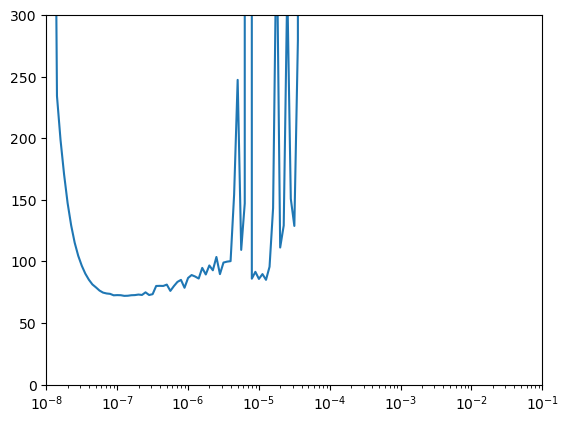

In [159]:
# plot different learning rates 
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history_lr.history["loss"])
plt.axis([1e-8, 1e-1, 0, 300])